# [IAPR 2018:][iapr2018] Lab 1 ‒  Image segmentation

**Author:** Milica Novakovic Number:281861

**Due date:** 20.04.2018

[iapr2018]: https://github.com/LTS5/iapr-2018

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
import numpy as np
import cv2 as cv
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

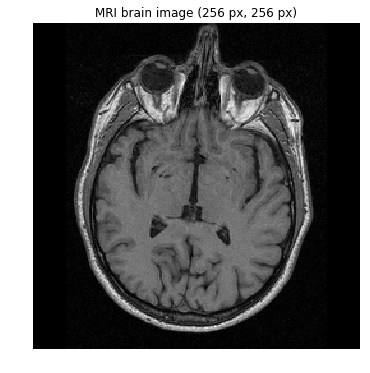

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Copy the image and use it as the place to hold the result.

In [3]:
brain_im=brain_im.astype(np.int32)
image_copy=brain_im.copy()

 First we check whether there is white color in the original image.If not, we use 255 as a mask

In [4]:
print(np.count_nonzero(brain_im==255))

0


In [5]:
# This function defines the criterion that the pixel is connected
Threshold = 10
def criterion(p1,p2):
    if abs(brain_im[p1[0],p1[1]]-brain_im[p2[0],p2[1]])<Threshold:
        return True
    else:
        return False

In [6]:
def region_growing(seed,criterion,image_size):
    # Define the stack that hold the pixels that need to deal with
    stack=[seed]
    # Define a array to be the flag that whether the pixels are already put in the stack
    # Otherwise,one pixel can be put in the stack multiple times
    already_put=np.zeros(image_size).astype(np.int32)
    already_put[seed[0],seed[1]]=1
    i=0
    while stack!=[]:
        # Pop one pixel in the stack
        p=stack.pop()
        x,y=p
        image_copy[x,y]=255
        # Check the pixels around them
        if (y+1<image_size[1]): 
            if criterion((x,y),(x,y+1)) and (already_put[x,y+1]== 0) :
                stack.append((x,y+1))
            already_put[x,y+1]=1
        if (x+1<image_size[0]):
            if  criterion((x,y),(x+1,y)) and (already_put[x+1,y]== 0):
                stack.append((x+1,y)) 
            already_put[x+1,y]=1
        if (x-1>=0): 
            if criterion((x,y),(x-1,y)) and (already_put[x-1,y]== 0):
                stack.append((x-1,y))
            already_put[x-1,y]=1
        if (y-1>=0):
            if criterion((x,y),(x,y-1)) and (already_put[x,y-1]== 0):
                stack.append((x,y-1))
            already_put[x,y-1]=1

 Do region growing with the seed 150,150

In [7]:
region_growing((150,150),criterion,(im_h,im_w))

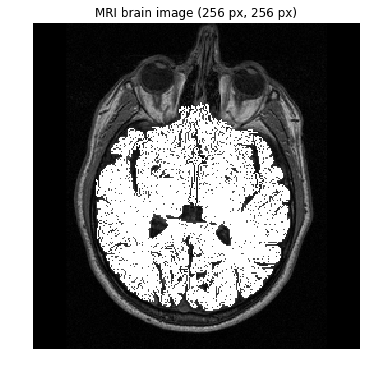

In [8]:
# Show the result in black and white
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(image_copy, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

In [9]:
# Count the area
print ("The area of the brain is")
print (np.count_nonzero(image_copy==255))

The area of the brain is
14771


### 1.3 Contour detection
As a first step we extracted edges using horizontal and vertical Sobel mask

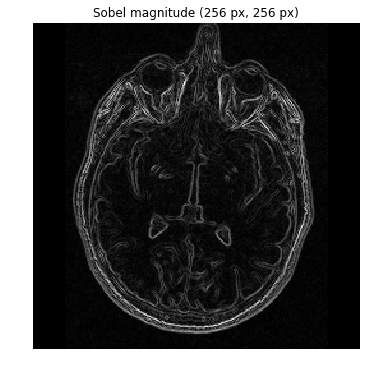

In [10]:
brain_im_gray = brain_im.astype(np.float)
gx = cv.Sobel(brain_im_gray, cv.CV_64F, 1, 0, ksize=1) # 1,0 means in the (1,0) direction
gy = cv.Sobel(brain_im_gray, cv.CV_64F, 0, 1, ksize=1)
# find the magnitude of the gradient
G = cv.magnitude(gx,gy)
im_h, im_w = brain_im.shape

# plot the gradient magnitude
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(G, cmap='gray')
ax.set_title('Sobel magnitude ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

In order to get rid of noisy edge, we have done Gaussian blurring of edge estimate and then Otsu thresholding. Obtained image is the left image. We have noticed that the brain nearly correspond to the connected component with the biggest area, and the second images represent all connected components in image. As the final step we have perform couple of erosions to get more accurate shape of the component with the biggest area. The appropriate area which correspond to brain is shown in the third image.

We do the contour by two steps.First, we find the area of the whole brain.And after that, we do contour finding to the inner brain to find the gray of the brain.

In [1]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
G = G.astype(np.uint8)
blur = cv.GaussianBlur(G,(7,7),3)

ret,thresh_blur= cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
thresh_inv = np.zeros_like(thresh_blur)
thresh_inv[thresh_blur<ret] = 255-thresh_blur[thresh_blur<ret]
ax[0].imshow(thresh_inv, cmap = "gray")

# we want to find the connected components
image, contours, hierarchy = cv.findContours(thresh_inv.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
max_cnt = max(contours, key = cv.contourArea)

# here we extract the white regions in the image that does not belong to the background
find_max_comp = np.zeros_like(thresh_inv)
find_max_comp = cv.drawContours(find_max_comp, [max_cnt], -1, (255,255,255), -1)
find_max_inv = 255 - find_max_comp

new_image = np.zeros_like(thresh_inv)
new_image[find_max_inv==np.max(find_max_comp)] = thresh_inv[find_max_inv==np.max(find_max_comp)]
ax[1].imshow(new_image, cmap = 'gray')

# since there is some additional, spirious components we will do some morphological operations
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2))
brain_cont = cv.erode(new_image.copy(),kernel,iterations = 3)
ax[2].imshow(brain_cont, cmap = 'gray')

image, contours, hierarchy = cv.findContours(brain_cont.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
second_max_cnt = max(contours, key = cv.contourArea)

# now we will make a mask that contain desired component, determined by index of contour second_max_cnt
mask = np.zeros(brain_cont.shape[:2], dtype="uint8")
cv.drawContours(mask, [second_max_cnt], -1, 255, -1)
large_comp = cv.bitwise_and(brain_cont, brain_cont, mask=mask)

print ("The area of the brain is")
print(cv.contourArea(second_max_cnt))
ax[2].imshow(large_comp, cmap = 'gray')
plt.show()

NameError: name 'plt' is not defined

### 1.4 Additional method(s)
We do k-means, meanshift and contrast limited adaptive histogram equilization for additional methods

In [12]:
from sklearn.cluster import KMeans

#First ,we generate the data for doing k-means.We stack the pixels and the positions information together.

X = brain_im.reshape((-1,1))
pos = np.array(np.unravel_index(range(len(X)),(im_h, im_w))).transpose().astype(np.float)
pos[:,0] = pos[:,0]*1.0/im_h
pos[:,1] = pos[:,1]*1.0/im_w
X = np.hstack((X,pos))

#Then, we do k-means and change anything that has not the same label as the inner part as the color white 
#Also, we keep the pixels which has the same cluster with the innner part as the color black

kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
segmentation = kmeans.labels_.reshape((im_h, im_w))
segmentation[segmentation!=0] = 255
segmentation = segmentation.astype(np.uint8)

#And we reverse the image for the convenience of the erode after 
segmentation = 255-segmentation

 Then ,we do the same thing as last part. Erode the picture and find the largest connection part, which is the brain

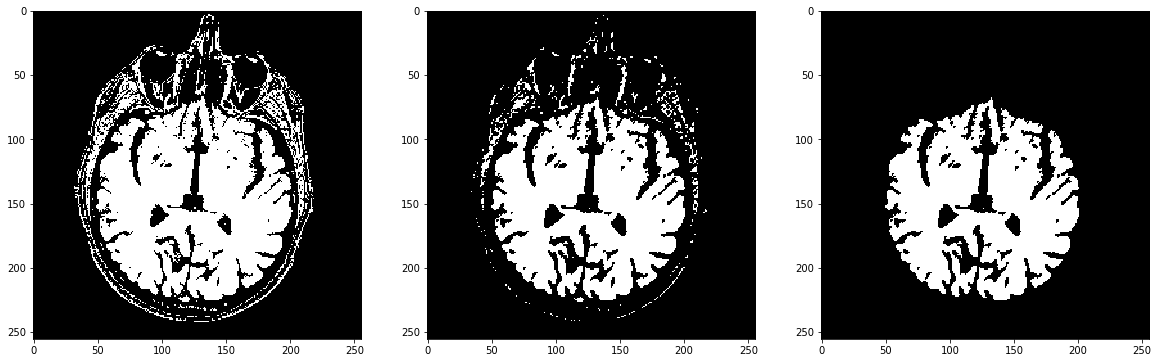

The area of the brain is
14530.5


In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
im_h, im_w = brain_im.shape

ax[0].imshow(segmentation, cmap='gray')

# At last , we do a little erode and find the gray because the gray is the greatest part now.
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2))
brain_cont = cv.erode(segmentation.copy(),kernel,iterations = 1)
ax[1].imshow(brain_cont, cmap = 'gray')

image, contours, hierarchy = cv.findContours(brain_cont.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
second_max_cnt = max(contours, key = cv.contourArea)  

# now we will make a mask that contain desired component, determined by index of contour second_max_cnt
mask = np.zeros(brain_cont.shape[:2], dtype="uint8")
cv.drawContours(mask, [second_max_cnt], -1, 255, -1)
large_comp = cv.bitwise_and(brain_cont, brain_cont, mask=mask)

ax[2].imshow(large_comp, cmap = 'gray')
plt.show()
# Compute the area
print ("The area of the brain is")
print(cv.contourArea(second_max_cnt))  
#print(np.count_nonzero(large_comp))

 Then, we try to apply meanshift to this problem

In [14]:
from sklearn.cluster import MeanShift
X = brain_im.reshape((-1,1))
meanshift = MeanShift(bandwidth=15 ,n_jobs=-1 ).fit(X)
segmentation = meanshift.labels_.reshape((im_h, im_w))

In [15]:
from scipy.stats import mode
label = mode(segmentation[100:200,70:170],axis=None)[0][0]
print ("label of brain is ",label)

#Then, we change anything that has not the same label as the inner part as the color white 
#Also, we keep the pixels which has the same cluster with the inner part as the color black
segmentation[segmentation!=label]=255
segmentation[segmentation==label]=0
segmentation=255-segmentation

#And we reverse the image for the convenience of the erode after 
segmentation=segmentation.astype(np.uint8)

label of brain is  1


Then ,we do the same thing as last part.Erode the picture and find the largest connection part, which is the brain.

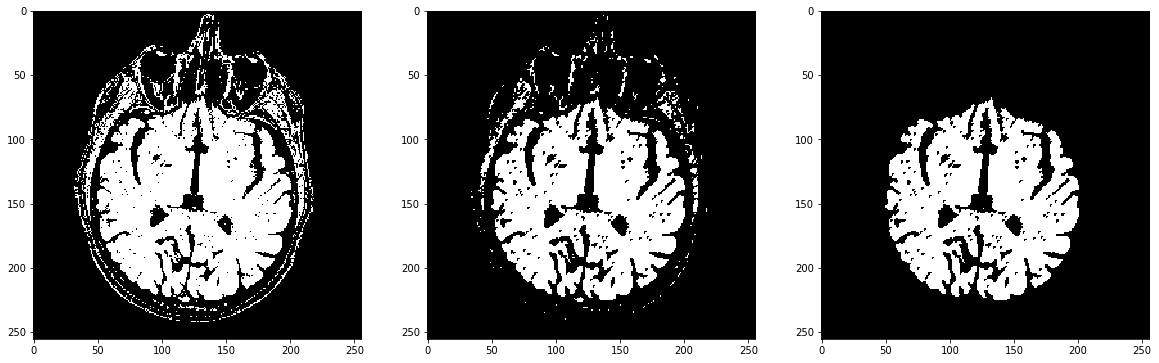

The area of the brain is
14841.5


In [16]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
im_h, im_w = brain_im.shape

ax[0].imshow(segmentation, cmap='gray')


# At last , we do a little erode and find the gray because the gray is the greatest part now.
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2))
brain_cont = cv.erode(segmentation.copy(),kernel,iterations = 1)
ax[1].imshow(brain_cont, cmap = 'gray')

image, contours, hierarchy = cv.findContours(brain_cont.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
second_max_cnt = max(contours, key = cv.contourArea)

# now we will make a mask that contain desired component
mask = np.zeros(brain_cont.shape[:2], dtype="uint8")
cv.drawContours(mask, [second_max_cnt], -1, 255, -1)
brain_cont = cv.bitwise_and(brain_cont, brain_cont, mask=mask)

ax[2].imshow(brain_cont, cmap = 'gray')
plt.show()
# Compute the area
print ("The area of the brain is")
print(cv.contourArea(second_max_cnt))

Here we will implement contrast limited adaptive histogram equilization, CLAHE. In the simple terms, this technique is very similar to histogram equilization which is used to increase contrast in whole image, while CLAHE divide image in the grid and apply for each block histogram equilization in order to achieve increase of contrast locally. One of the parameters of CLAHE is block size, by default 8x8 and clipLimit ratio which does not allow bigger than clipLimit times increase in pixel value before and after equilization. For more details, consult:https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html 

After the CLAHE, we do threshold, and we can segement the picture as good as the k-means that we did before.And we find the biggest connected part,which is the brain.

The area of the brain is
13698.5


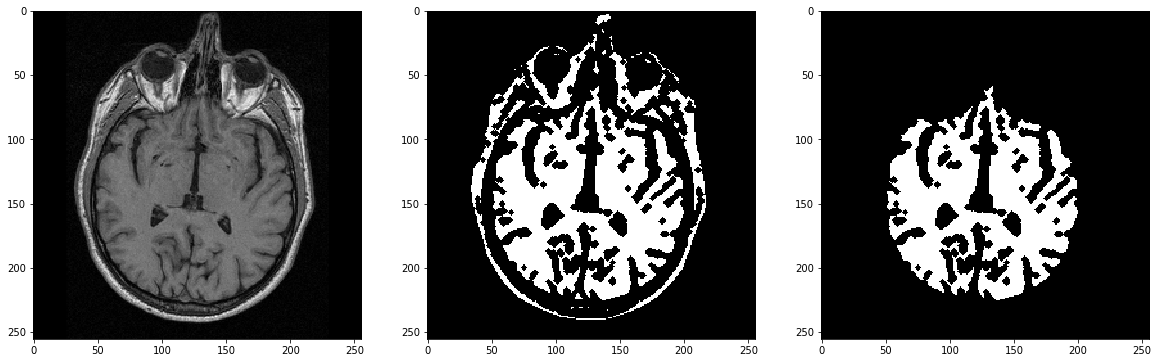

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
blur_edges = cv.bilateralFilter(brain_im,5,8,8)

# we will use contrast limited adaptive histogram equilization as described above
clahe = cv.createCLAHE(clipLimit=5.0, tileGridSize=(15,15))
cl = np.zeros_like(blur_edges)
cl = clahe.apply(blur_edges)
_,thresh= cv.threshold(cl,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

# morphological operations to disconnect the brain
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
edges_eroded = cv.erode(thresh,kernel,iterations = 2)
ax[0].imshow(brain_im, cmap = 'gray')

ax[1].imshow(edges_eroded, cmap = 'gray')

#we want to find contours, more imortantly index of the largest contour
image, contours, hierarchy = cv.findContours(edges_eroded.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
max_cnt = max(contours, key = cv.contourArea)

# now we will make a mask that contain desired comp
mask = np.zeros(edges_eroded.shape[:2], dtype="uint8")
cv.drawContours(mask, [max_cnt], -1, 255, -1)
large_comp = cv.bitwise_and(edges_eroded, edges_eroded, mask=mask)

ax[2].imshow(large_comp, cmap = 'gray')
print ("The area of the brain is")
print(cv.contourArea(max_cnt))

plt.show()

All the methods above achieve the similar results, with some small difference.
Region based methods gives accurate outline of the brain, but there is noise.
Contour based method gives a rough estimate of the brain.

## Part 2: Shape/color segmentation

You will find hereafter a picture of shapes of different colors, taken under four different illuminations.
We ask you to create a routine to:
1. Count the number of shapes of each color.
1. Compute the total area (in pixels) of each color.

One specific challenge is to be robust to illumination changes.
Try to have the same routine(s) running on the four images, and giving (approximatively) the same results.
Therefore some kind of intensity normalization should probably be used.
To help you, you will also find a reference image (palette) with disks of each possible color, that you can use as references.

**Note:** the routine(s) that you will write for this part will be useful for the robot project as well, so pay special attention to it.

### 2.1 Images and palette visualization

In [18]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03', 'arena-shapes-04']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  4
Image size: 480, 640 
Number of color channels:  3


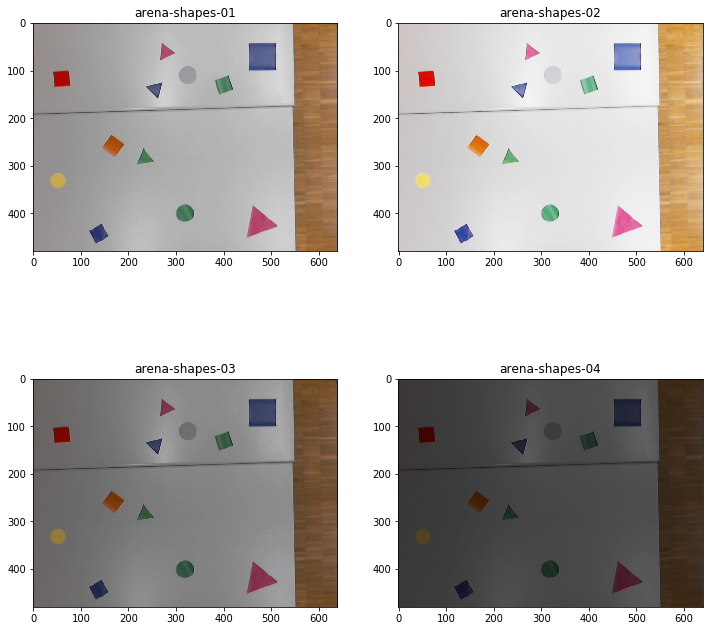

In [19]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    #ax.axis('off')
    ax.set_title(nm)
plt.show()

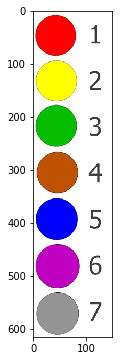

In [20]:
# Load and plot palette
palette = skimage.io.imread(os.path.join(data_path, 'arena-palette.png'))
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(palette)
plt.show()

First we extract the color of the palette and put them in the dictionary.

In [21]:
color_dict={}
for i in range(1,8):
    color_dict[str(i)]=palette[-40+82*i,50,:]

In [22]:
print (color_dict)

{'1': array([254,   0,   0], dtype=uint8), '2': array([255, 255,   0], dtype=uint8), '3': array([  6, 190,   0], dtype=uint8), '4': array([191,  82,   0], dtype=uint8), '5': array([  0,   0, 254], dtype=uint8), '6': array([191,   0, 192], dtype=uint8), '7': array([148, 148, 148], dtype=uint8)}


Then we give a name to each color

In [23]:
color_name_list={1:"red",2:"yellow",3:"green",4:"brown",5:"blue",6:"purple",7:"gray"}

We add the function of finding colors.
This function is found by oberseving the RGB value of the color and combine it with some prior knowledge of color

In [24]:
def find_color(rgb):
    R,G,B=rgb
    if R>180:
        if B>G+5 and R>G*0.1+0.9*B:
            return color_name_list[6]
        if G>B+15:
            if G>225:
                return color_name_list[2]
            if G<225:
                if not (G>B and G>R):
                    return color_name_list[4]
    if R>G+10 and R>B+10 and R>215:
        return color_name_list[1]
    if B>R+10 and B>G+10:
        return color_name_list[5]
    if G>B and G>R:
        return color_name_list[3]
    if abs(G-B)<10 and abs(G-R)<10 and abs(R-B)<10:
        return color_name_list[7]        
    return None    

Try this function with the palette, and we can find it works perfectly well!

In [25]:
for i,color in color_dict.items():
    print ("real color",color_name_list[int(i)].ljust(6, ' '),"find color",find_color(color.tolist()).ljust(6, ' '))

real color red    find color red   
real color yellow find color yellow
real color green  find color green 
real color brown  find color brown 
real color blue   find color blue  
real color purple find color purple
real color gray   find color gray  


 Okay, now we finish our preparation and we can begin!

### 2.2 Number of shapes of each color


First we do the threshold for different channels.Because the gray circle is really hard to be detected so we do adaptive gaussian threshold for the red channel , since it is the red channel that can find the gray circle with the least effort.But since the adaptive gaussian threshold can add a lot of noise, we do OTSU threshold for the green and the blue channel.

In [26]:
channel=[]

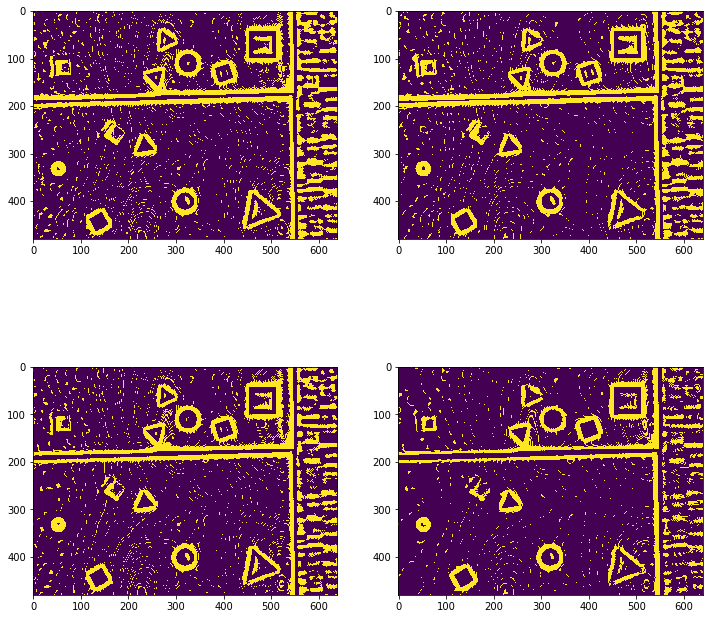

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im in zip(axes.ravel(), images):
    blur = cv.bilateralFilter(im[:,:,0],15,30,10)
    thresh_lighting = cv.adaptiveThreshold(blur,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,15,0)
    ax.imshow(thresh_lighting)
    channel.append(thresh_lighting)
plt.show()

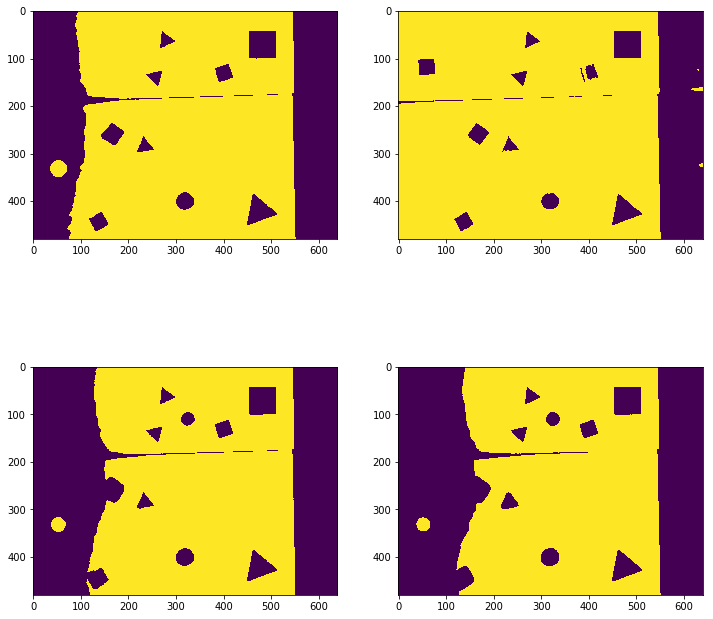

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im in zip(axes.ravel(), images):
    blur = cv.bilateralFilter(im[:,:,1],15,30,10)
    _, thresh_lighting = cv.threshold(blur, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    ax.imshow(thresh_lighting)
    channel.append(thresh_lighting)
plt.show()

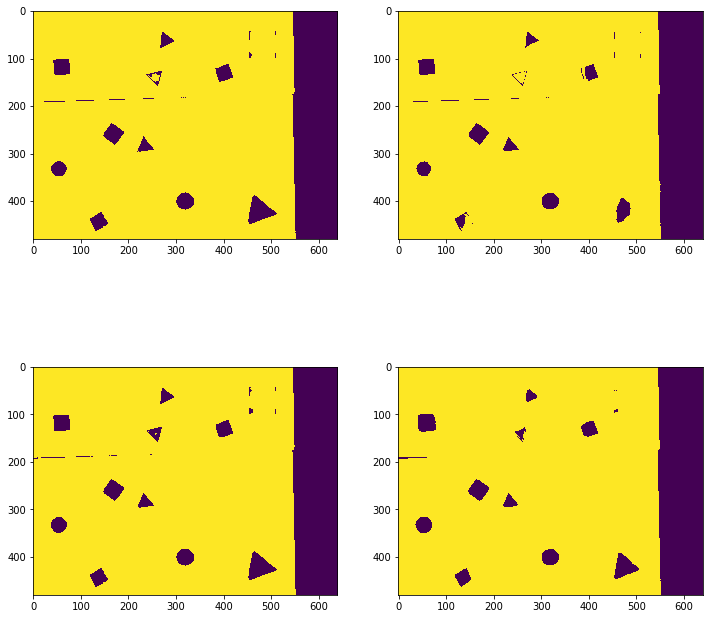

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im in zip(axes.ravel(), images):
    blur = cv.bilateralFilter(im[:,:,2],15,30,10)
    _, thresh_lighting = cv.threshold(blur, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    ax.imshow(thresh_lighting)
    channel.append(thresh_lighting)
plt.show()

After that, we will combine the information of these three channels to find the shape. Before that, we first do a normalization to our picture to make the color detection easier because the illumination affect too much on the color right now. From original picture we observe that background has gray shade which is not unique for each picture due to illumination changes. 

We would like to measure illumination changes on the background and to equilize them.
We estimate background color in each image as median value for each channel independently, since the most pixels belong to background and we expect that color shapes behaves as outliers, we would cut the influence by using median instead mean average.

Our method is for every channel

pixel=0.9\*(pixel-median of this channel)+0.1\*(pixel-median of the red channel)

We use more of red channel to keep the picture to look like a bit dark so that we can easily distinguish the color.

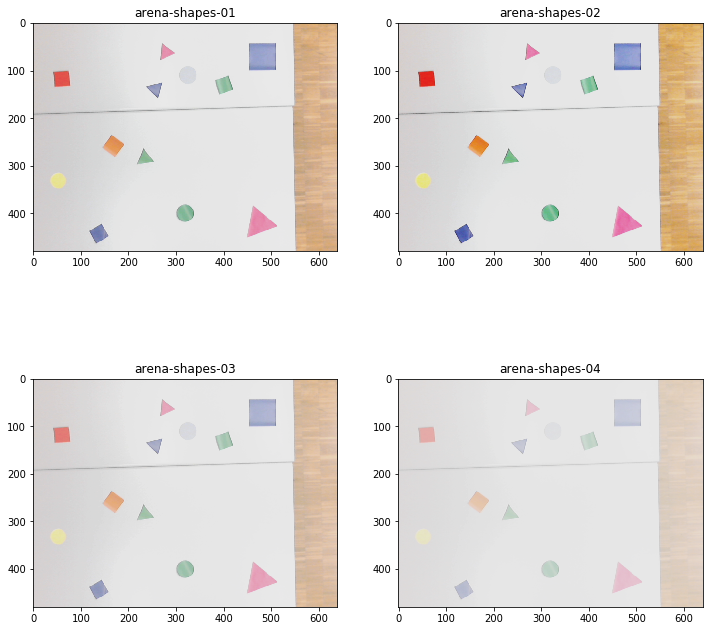

In [30]:
im_sub_list=[]
fig, axes = plt.subplots(2,2, figsize=(12, 12))
for im, ax, nm in zip(images, axes.ravel(),im_names):
    avg_red_val = np.median(im[:,:,0])
    avg_green_val = np.median(im[:,:,1])
    avg_blue_val = np.median(im[:,:,2])
    im_sub = im.copy()
    im_sub = np.float32(im_sub)

    im_0 = np.clip(im_sub[:,:,0] - avg_red_val + 255, 0, 255)*0.9+np.clip(im_sub[:,:,0] - avg_red_val, 0, 255)*0.1
    im_sub[:,:,0] = im_0
    im_1 = np.clip(im_sub[:,:,1]  - avg_green_val + 255, 0, 255)*0.9+np.clip(im_sub[:,:,1] - avg_red_val, 0, 255)*0.1
    im_sub[:,:,1] = im_1
    im_2 = np.clip(im_sub[:,:,2]  - avg_blue_val + 255, 0, 255)*0.9+np.clip(im_sub[:,:,2] - avg_red_val, 0, 255)*0.1
    im_sub[:,:,2] = im_2

    im_sub = im_sub.astype('uint8')
    
    ax.set_title(nm)
    im_sub_list.append(im_sub)
    ax.imshow(im_sub)

We put the threshold image into the array for the use after.

In [31]:
im1_binary=[channel[i].astype(np.uint8) for i in range(0,12,4)]
im2_binary=[channel[i].astype(np.uint8) for i in range(1,12,4)]
im3_binary=[channel[i].astype(np.uint8) for i in range(2,12,4)]
im4_binary=[channel[i].astype(np.uint8) for i in range(3,12,4)]

We define some function now.First is assert shape, we use this function to find whether a contour is a shape.For a shape, the square of the perimeter divide the area should not be too large or too small.The threshold can be found approximately by computing the the square of the perimeter divide the area of the shape triangle,circle and the square.

In [32]:
def assert_shape(s,l):
    if l**2/s>8 and l**2/s<25:
        return True
    else:
        return False

 This function found the contour from the binary image and put the reasonable contour into the list(The area is not too high or too low,the length is not too high and the assert_shape function can be passed).

In [33]:
AREA_LOW_BOUND=400
AREA_HIGH_BOUND=8000
LENGTH_HIGH_BOUND=500

In [34]:
def find_reasonable_contours(binary_list):
    img_cont_list=[]
    for img in binary_list:
        im2,contours,hierarchy = cv.findContours(img, 1, 2)
        for cont in contours:
            s=cv.contourArea(cont)
            l=cv.arcLength(cont,True)
            if s>AREA_LOW_BOUND and s<AREA_HIGH_BOUND and l<LENGTH_HIGH_BOUND:
                    if assert_shape(s,l):
                        img_cont_list.append(cont)
    return img_cont_list

In [35]:
img1_cont_list=find_reasonable_contours(im1_binary)
img2_cont_list=find_reasonable_contours(im2_binary)
img3_cont_list=find_reasonable_contours(im3_binary)
img4_cont_list=find_reasonable_contours(im4_binary)
img_cont_list=[img1_cont_list,img2_cont_list,img3_cont_list,img4_cont_list]

Now the contour is multiple.They have some overlap.

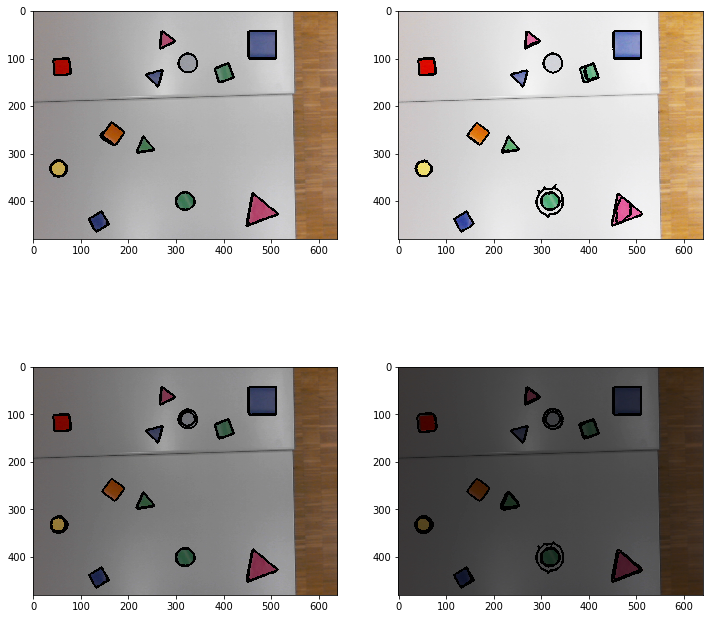

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im ,nm in zip(axes.ravel(), images, range(0,4)):
    im_cont=im.copy()
    cv.drawContours(im_cont, img_cont_list[nm], -1, (0,0,0), 3)
    ax.imshow(im_cont)
plt.show()  

Now we try to keep only one contour for one shape.First we define a function,this function find whether the point is in the circle.This will be used to remove overlap contours.

In [37]:
def in_circle(point,middle,r):
    if ((point[0]-middle[0])**2+(point[1]-middle[1])**2)<=r**2:
        return True
    else:
        return False

 So this function removes the overlap of the contour.We fit a circle for each contour, if the center of the circle already in the circle fit by other contours, then we drop the contour.

In [38]:
def remove_overlap(img_cont_list):    
    set_contour=[]
    set_contour_pixel=[]
    for cont in img_cont_list:
        (x_,y_),radius_ = cv.minEnclosingCircle(cont)
        flag=False
        for x,y,radius in set_contour:
            if in_circle((x_,y_),(x,y),radius):
                flag=True
        if flag==False:
            set_contour.append((x_,y_,radius_))
            set_contour_pixel.append(cont)
    return set_contour_pixel

In [39]:
set_contour_pixel1=remove_overlap(img1_cont_list)
set_contour_pixel2=remove_overlap(img2_cont_list)
set_contour_pixel3=remove_overlap(img3_cont_list)
set_contour_pixel4=remove_overlap(img4_cont_list)
set_contour_pixel=[set_contour_pixel1,set_contour_pixel2,set_contour_pixel3,set_contour_pixel4]

Now we can see the shapes we found

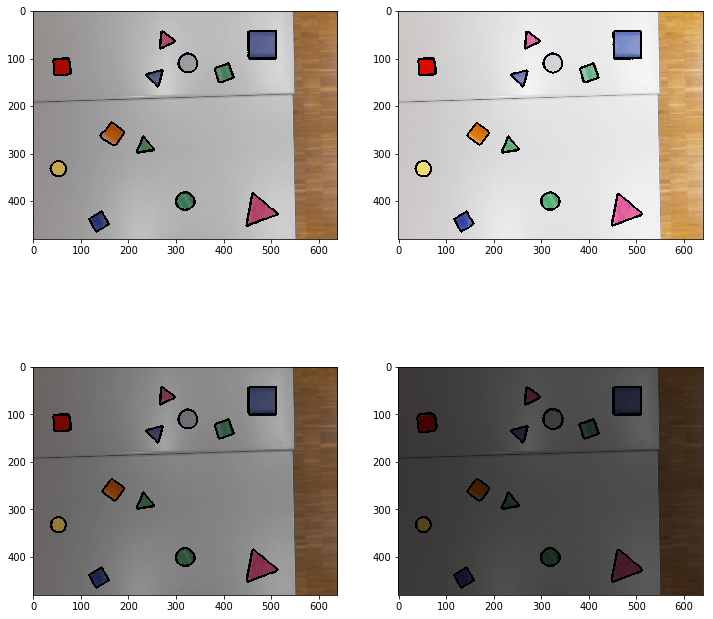

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im ,nm in zip(axes.ravel(), images, range(0,4)):
    im_cont=im.copy()
    cv.drawContours(im_cont, set_contour_pixel[nm], -1, (0,0,0), 3)
    ax.imshow(im_cont)
plt.show()

 Now write a shape detection function. We first fit the minimum enclosing circle of the contour.If the area of the contour and the circle are almost equal, we can say the contour is a circle.Else, we fit a approximation of the contour and check how many vertex the approximation has , we know it is square or triangle.

In [41]:
import math
def detect_shape(cont):
    (x,y),r = cv.minEnclosingCircle(cont)
    a=cv.contourArea(cont)
    #print (a)
    #print (math.pi*r*r)
    if abs(a-math.pi*r*r)<0.5*r*r:
        return ("circle")
    epsilon = 0.1*cv.arcLength(cont,True)
    approx = cv.approxPolyDP(cont,epsilon,True)
    if len(approx) == 4:
        return ("square")
    elif len(approx) == 3:
        return ("triangle")
    else:
        return ("None")

This function extract every patch of shape from image and compute the average color of each shape.It returns a dict, which contains 12 elements of shapes and their colors and area.

In [42]:
def extract_color_patch(image,set_contour_pixel):
    shape_dict={}
    for i,cont in enumerate(set_contour_pixel):
        # Draw the contours to make the mask
        im_cont=image.copy().astype(np.float)
        im_mask=np.zeros_like(im_cont)
        im_mask=cv.drawContours(im_mask, [cont], -1, (1,1,1), -1)
        # Compute the average color of the patch
        mean_val = np.sum(im_cont*im_mask,axis=(0,1))
        area=cv.contourArea(cont)
        shape=detect_shape(cont)
        shape_dict[i]=(mean_val/area,area,shape)
    return shape_dict

Note that we use the picture after normalization to extract the patch

In [43]:
shape_dict1=extract_color_patch(im_sub_list[0],set_contour_pixel1)
shape_dict2=extract_color_patch(im_sub_list[1],set_contour_pixel2)
shape_dict3=extract_color_patch(im_sub_list[2],set_contour_pixel3)
shape_dict4=extract_color_patch(im_sub_list[3],set_contour_pixel4)

 Now we have the dict with 12 patchs as elements, each element includes their color and area and shape.We see shape_dict1 for example.

In [44]:
print (shape_dict1)

{0: (array([ 136.81580298,  143.9969215 ,  184.7429451 ]), 974.5, 'square'), 1: (array([ 237.70920018,  158.81460934,  188.43550624]), 2163.0, 'triangle'), 2: (array([ 150.84326306,  194.15673694,  169.55820348]), 1091.0, 'circle'), 3: (array([ 245.02191609,  238.87664371,  162.19787101]), 798.5, 'circle'), 4: (array([ 165.8633035 ,  202.13018714,  175.38812042]), 614.5, 'triangle'), 5: (array([ 167.54049587,  171.87933884,  200.36694215]), 605.0, 'triangle'), 6: (array([ 167.2301665 ,  203.64740451,  181.86973555]), 1021.0, 'square'), 7: (array([ 225.26532326,  227.29974811,  232.12510495]), 1191.0, 'circle'), 8: (array([ 160.1461621 ,  168.89842194,  207.36387314]), 3263.5, 'square'), 9: (array([ 230.75400291,  173.31295488,  132.86317322]), 1374.0, 'square'), 10: (array([ 239.6195044 ,  172.12629896,  195.09192646]), 625.5, 'triangle'), 11: (array([ 230.09956332,  107.57816594,  100.49694323]), 1145.0, 'square')}


Now is the last step.We use the pre-defined find_color function to distinguish the color and print the shape and the area of each color patch.

In [45]:
def print_result(shape_dict):
    for i in shape_dict.keys():
        # Get the rgb value
        rgb=shape_dict[i][0]
        # Get the color
        color=find_color(rgb)
        area=shape_dict[i][1]
        shape=shape_dict[i][2]
        print ("patch",i,", color value =",rgb)
        print ("color name is",color,", shape is",shape,", area equals",area)

Now we print each result.

In [46]:
print_result(shape_dict1)

patch 0 , color value = [ 136.81580298  143.9969215   184.7429451 ]
color name is blue , shape is square , area equals 974.5
patch 1 , color value = [ 237.70920018  158.81460934  188.43550624]
color name is purple , shape is triangle , area equals 2163.0
patch 2 , color value = [ 150.84326306  194.15673694  169.55820348]
color name is green , shape is circle , area equals 1091.0
patch 3 , color value = [ 245.02191609  238.87664371  162.19787101]
color name is yellow , shape is circle , area equals 798.5
patch 4 , color value = [ 165.8633035   202.13018714  175.38812042]
color name is green , shape is triangle , area equals 614.5
patch 5 , color value = [ 167.54049587  171.87933884  200.36694215]
color name is blue , shape is triangle , area equals 605.0
patch 6 , color value = [ 167.2301665   203.64740451  181.86973555]
color name is green , shape is square , area equals 1021.0
patch 7 , color value = [ 225.26532326  227.29974811  232.12510495]
color name is gray , shape is circle , ar

In [47]:
print_result(shape_dict2)

patch 0 , color value = [ 107.35104167  117.66666667  181.64895833]
color name is blue , shape is square , area equals 960.0
patch 1 , color value = [ 128.78023529  195.01458824  158.544     ]
color name is green , shape is circle , area equals 1062.5
patch 2 , color value = [ 243.88343558  239.7607362   149.59018405]
color name is yellow , shape is circle , area equals 815.0
patch 3 , color value = [ 147.91333333  202.36666667  162.59166667]
color name is green , shape is triangle , area equals 600.0
patch 4 , color value = [ 150.54149204  156.94216262  198.87510478]
color name is blue , shape is triangle , area equals 596.5
patch 5 , color value = [ 153.00905433  205.33299799  175.68309859]
color name is green , shape is square , area equals 994.0
patch 6 , color value = [ 228.65230004  230.42022379  234.59179445]
color name is gray , shape is circle , area equals 1206.5
patch 7 , color value = [ 145.49492425  159.34999219  210.4401062 ]
color name is blue , shape is square , area eq

In [48]:
print_result(shape_dict3)

patch 0 , color value = [ 165.21146953  169.59037378  198.31233999]
color name is blue , shape is square , area equals 976.5
patch 1 , color value = [ 175.39122569  204.99412031  187.81184984]
color name is green , shape is circle , area equals 1105.5
patch 2 , color value = [ 245.65641026  240.00641026  182.58205128]
color name is yellow , shape is circle , area equals 780.0
patch 3 , color value = [ 187.75645161  212.66612903  193.88225806]
color name is green , shape is triangle , area equals 620.0
patch 4 , color value = [ 189.26246934  191.62224039  211.64349959]
color name is blue , shape is triangle , area equals 611.5
patch 5 , color value = [ 187.26346434  212.13197477  196.87142164]
color name is green , shape is square , area equals 1030.5
patch 6 , color value = [ 228.07518797  228.7593985   233.00835422]
color name is gray , shape is circle , area equals 1197.0
patch 7 , color value = [ 180.64842681  186.15777474  213.32634139]
color name is blue , shape is square , area e

In [49]:
print_result(shape_dict4)

patch 0 , color value = [ 199.87506348  202.34027425  218.05485018]
color name is blue , shape is square , area equals 984.5
patch 1 , color value = [ 204.98429789  221.03903096  211.77119785]
color name is green , shape is circle , area equals 1114.5
patch 2 , color value = [ 244.49446975  241.3597918   209.97267404]
color name is yellow , shape is circle , area equals 768.5
patch 3 , color value = [ 214.96993671  228.36708861  218.42405063]
color name is green , shape is triangle , area equals 632.0
patch 4 , color value = [ 216.08555287  217.41404358  228.25504439]
color name is blue , shape is triangle , area equals 619.5
patch 5 , color value = [ 212.49040307  225.99424184  217.64395393]
color name is green , shape is square , area equals 1042.0
patch 6 , color value = [ 235.65217391  236.13348589  238.08543097]
color name is gray , shape is circle , area equals 1311.0
patch 7 , color value = [ 206.34896697  209.38742271  224.15080682]
color name is blue , shape is square , area e

All four pictures get the same result on the shape and the color, and the area are almost equal.

### 2.3 Total area (in pixels) of each color
We will define function to sum for each color all areas of different shapes, and then we will utilise this function on each image

In [50]:
def total_area(shape_dict, total_area_by_color):
    for i in shape_dict.keys():
        # Get the rgb value
        rgb=shape_dict[i][0]
        # Get the color
        color=find_color(rgb)
        area = shape_dict[i][1]
        total_area_by_color[color]+=area
    return total_area_by_color

In [51]:
color_names = color_name_list.values()
total_area_by_color = dict(zip(color_names, [0]*len(color_names)))
total_area_by_color = total_area(shape_dict1, total_area_by_color)
#print(total_area_by_color)

In [52]:
for color, area in total_area_by_color.items():
    print("Total area of color " ,color.ljust(6)," = ",area)

Total area of color  red     =  1145.0
Total area of color  yellow  =  798.5
Total area of color  green   =  2726.5
Total area of color  brown   =  1374.0
Total area of color  blue    =  4843.0
Total area of color  purple  =  2788.5
Total area of color  gray    =  1191.0


In [53]:
color_names = color_name_list.values()
total_area_by_color = dict(zip(color_names, [0]*len(color_names)))
total_area_by_color = total_area(shape_dict2, total_area_by_color)
#print(total_area_by_color)

In [54]:
for color, area in total_area_by_color.items():
    print("Total area of color " ,color.ljust(6)," = ",area)

Total area of color  red     =  1158.5
Total area of color  yellow  =  815.0
Total area of color  green   =  2656.5
Total area of color  brown   =  1170.0
Total area of color  blue    =  4758.0
Total area of color  purple  =  2713.5
Total area of color  gray    =  1206.5


In [55]:
color_names = color_name_list.values()
total_area_by_color = dict(zip(color_names, [0]*len(color_names)))
total_area_by_color = total_area(shape_dict3, total_area_by_color)
#print(total_area_by_color)

In [56]:
for color, area in total_area_by_color.items():
    print("Total area of color " ,color.ljust(6)," = ",area)

Total area of color  red     =  1166.5
Total area of color  yellow  =  780.0
Total area of color  green   =  2756.0
Total area of color  brown   =  1180.0
Total area of color  blue    =  4877.5
Total area of color  purple  =  2810.5
Total area of color  gray    =  1197.0


In [57]:
color_names = color_name_list.values()
total_area_by_color = dict(zip(color_names, [0]*len(color_names)))
total_area_by_color = total_area(shape_dict4, total_area_by_color)
#print(total_area_by_color)

In [58]:
for color, area in total_area_by_color.items():
    print("Total area of color " ,color.ljust(6)," = ",area)

Total area of color  red     =  1369.5
Total area of color  yellow  =  768.5
Total area of color  green   =  2788.5
Total area of color  brown   =  1226.5
Total area of color  blue    =  4919.5
Total area of color  purple  =  2870.0
Total area of color  gray    =  1311.0


There is a small variation in the detected number of pixels for each color across the different images, we could see that red pixels are most sensitive to illumination changes